## Thin plate spline

Find an interpolating surface to a set of control points with minimum bend. For image interpolation consider two such surfaces, one for each principal axis.

### References
[1] Donato, G., & Belongie, S. J. (2003). Approximation methods for thin plate spline mappings and principal warps. Department of Computer Science and Engineering, University of California, San Diego.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import thinplate.numpy as tpsnp
import thinplate.pytorch as tpspth

Fit surface through control points and visualize

<a list of 7 text.Text objects>

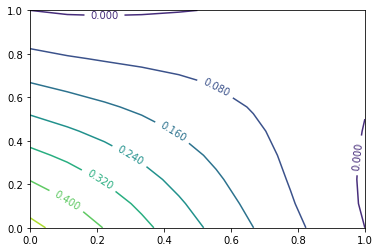

In [4]:
c = np.array([
    [0., 0, 0.5],
    [1., 0, 0.0],
    [1., 1, 0.0],
    [0, 1, 0.0],
])

theta = tpsnp.TPS.fit(c)
X,Y,xy = tpsnp.normalized_grid((10,10))
Z = tpsnp.TPS.z(xy, c, theta).reshape(10, 10)

fig, ax = plt.subplots()
c = ax.contour(X, Y, Z)
ax.clabel(c, inline=1, fontsize=10)

For image interpolation, we define a separate surface for x and y offsets.

In [5]:
def warp_image_cv(img, c_src, c_dst, dshape=None):
    dshape = dshape or img.shape
    grid = tpsnp.compute_densegrid(c_src, c_dst, dshape)
    return cv2.remap(img, grid[:, :, 0] * img.shape[1], grid[:, :, 1] * img.shape[0], cv2.INTER_CUBIC)


In [6]:
def show_warped(img, warped):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img[...,::-1], origin='upper')
    axs[0].scatter(c_src[:, 0]*img.shape[1], c_src[:, 1]*img.shape[0], marker='+', color='black')
    axs[1].imshow(warped[...,::-1], origin='upper')
    axs[1].scatter(c_dst[:, 0]*warped.shape[1], c_dst[:, 1]*warped.shape[0], marker='+', color='black')
    plt.show()

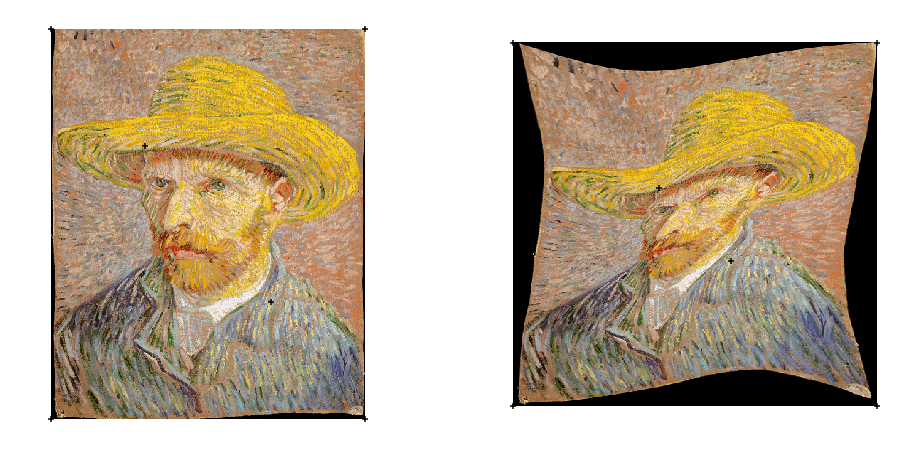

In [7]:
import cv2
img = cv2.imread('image.png')

c_src = np.array([
    [0.0, 0.0],
    [1., 0],
    [1, 1],
    [0, 1],
    [0.3, 0.3],
    [0.7, 0.7],
])

c_dst = np.array([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
])
    
warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

Same as with OpenCV but using pytorch sampling

In [8]:
import torch
import torch.nn.functional as F

In [9]:
def warp_image_pytorch(img, c_src, c_dst, dshape=None):    
    dshape = dshape or img.shape
    grid = tpsnp.compute_densegrid(c_src, c_dst, dshape)
    grid = grid * 2 - 1 # [-1,1] range required
    
    img = torch.as_tensor(img, dtype=torch.float32).permute(2,1,0).unsqueeze(0) / 255.
    grid = torch.as_tensor(grid).unsqueeze(0)
    
    img = F.grid_sample(img, grid)
    img = (img * 255).to(torch.uint8).squeeze(0).permute(2,1,0).numpy()
    return img

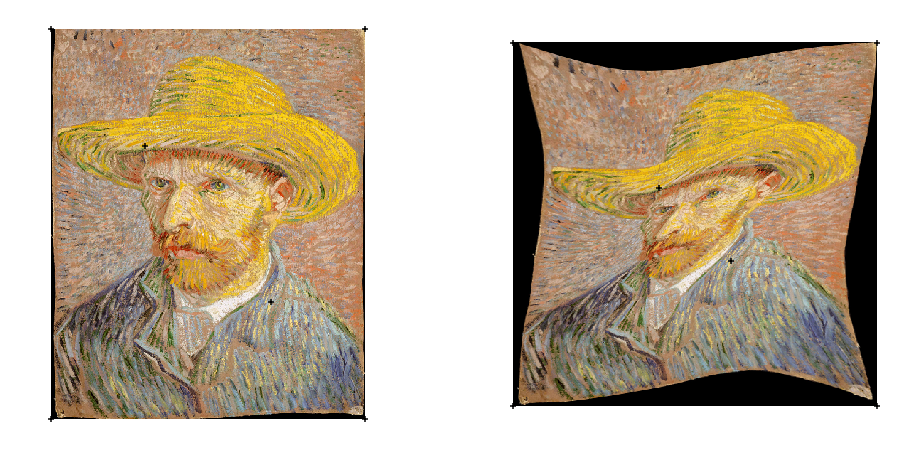

In [10]:
warped = warp_image_pytorch(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

tensor(0.4693, grad_fn=<MeanBackward1>)
tensor([[-0.0995,  0.1145,  0.1196, -0.0759, -0.0049, -0.0313,  0.0892, -0.3150,
          0.0125],
        [-0.0963, -0.1066,  0.1115,  0.0950,  0.0141, -0.0051, -0.0287, -0.0240,
         -0.3682]])


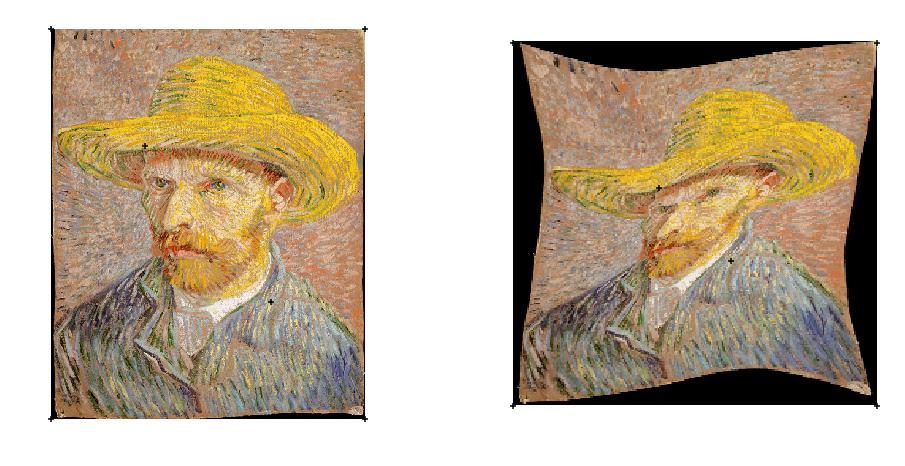

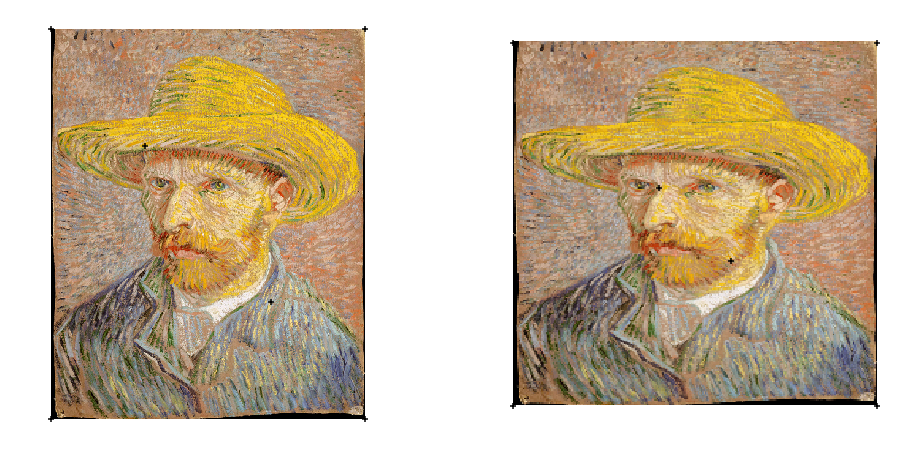

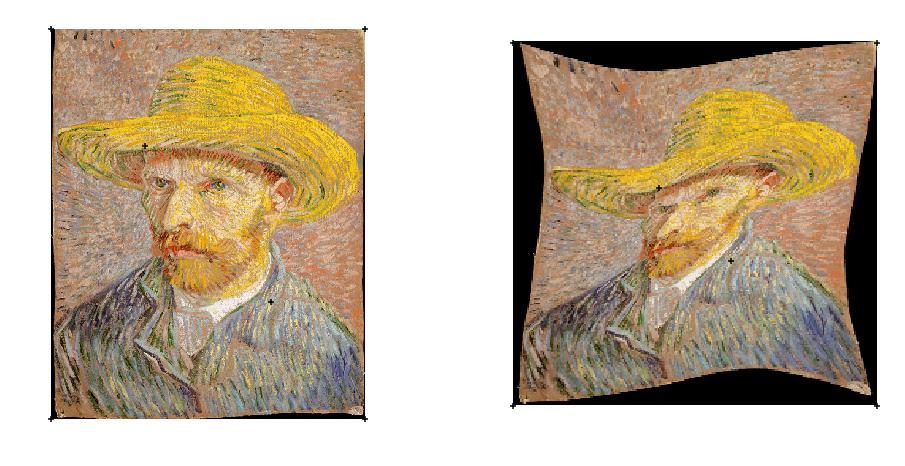

In [11]:
c_dst = torch.tensor([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
])

theta = torch.tensor([
    [ 0.21,  2.77555756e-17, -2.02179003e-01,  1.56714090e-17,
 -1.01189501e+00,  1.01089501e+00,  7.53939805e-02, -7.53939805e-02,
 -7.53939805e-02],
[ 2.02179003e-01,  2.77555756e-17, -2.02179003e-01,  1.56714090e-17,
 -1.01089501e+00,  1.01089501e+00,  7.53939805e-02, -7.53939805e-02,
 -7.53939805e-02]
], requires_grad=True)

theta_rep = theta.transpose(0,1).unsqueeze(0).expand(3,9,2).contiguous()
theta_rep[1] = 0
size = (3, 3, 256, 256)

img = cv2.imread('image.png')
img = torch.as_tensor(img, dtype=torch.float32).permute(2,1,0).unsqueeze(0) / 255.
img = img.expand(3, *img.shape[1:])

grid = tpspth.tps_grid(theta_rep, c_dst, size)
warped = F.grid_sample(img, grid)

loss = warped.mean()
print(loss)
loss.backward()
print(theta.grad)

warped = (warped * 255).to(torch.uint8).squeeze(0).permute(0,3,2,1).numpy()
show_warped(cv2.imread('image.png'), warped[0])
show_warped(cv2.imread('image.png'), warped[1])
show_warped(cv2.imread('image.png'), warped[2])


#grid = torch.as_tensor(grid).unsqueeze(0)
    
#img = F.grid_sample(img, grid)
#


1.0


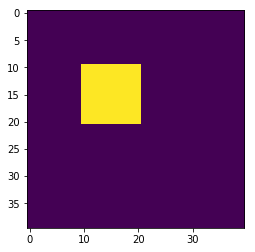

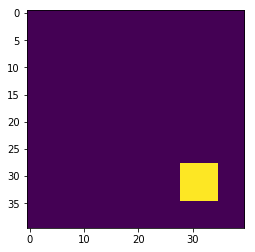

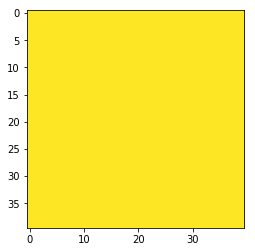

In [12]:
img = torch.zeros(2, 1, 40, 40)
img[0,..., 10:21, 10:21] = 1
img[1,..., 28:35, 28:35] = 1

print(img[0].permute(1,2,0).numpy().squeeze().max())

plt.imshow(img[0].permute(1,2,0).numpy().squeeze())
plt.show()

plt.imshow(img[1].permute(1,2,0).numpy().squeeze())
plt.show()


c_dst = torch.tensor([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],  
])


c_src = torch.tensor([
    [10., 10],
    [20., 10],    
    [20, 20],
    [10, 20],  
]) / 40.

img_cv = (img[0].permute(1,2,0).numpy()*255).astype(np.uint8)
grid = tpsnp.compute_densegrid(c_src, c_dst, img_cv.shape)

warped = warp_image_cv(img_cv, c_src, c_dst)
plt.imshow(warped, vmin=0, vmax=1)

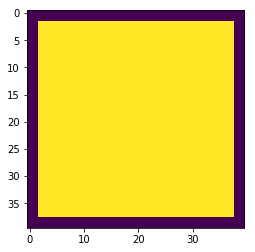

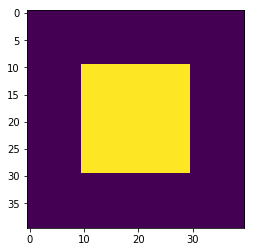

tensor(0.5050, grad_fn=<MseLossBackward>) tensor(0.0531, grad_fn=<MeanBackward1>)
tensor(0.3493, grad_fn=<MseLossBackward>) tensor(0.1725, grad_fn=<MeanBackward1>)
tensor(0.1684, grad_fn=<MseLossBackward>) tensor(0.4115, grad_fn=<MeanBackward1>)
tensor(0.0877, grad_fn=<MseLossBackward>) tensor(0.5458, grad_fn=<MeanBackward1>)
tensor(0.0604, grad_fn=<MseLossBackward>) tensor(0.5335, grad_fn=<MeanBackward1>)
tensor(0.0434, grad_fn=<MseLossBackward>) tensor(0.5392, grad_fn=<MeanBackward1>)
tensor(0.0327, grad_fn=<MseLossBackward>) tensor(0.5372, grad_fn=<MeanBackward1>)
tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.5382, grad_fn=<MeanBackward1>)
tensor(0.0251, grad_fn=<MseLossBackward>) tensor(0.5397, grad_fn=<MeanBackward1>)
tensor(0.0232, grad_fn=<MseLossBackward>) tensor(0.5390, grad_fn=<MeanBackward1>)
tensor(0.0199, grad_fn=<MseLossBackward>) tensor(0.5355, grad_fn=<MeanBackward1>)
tensor(0.0173, grad_fn=<MseLossBackward>) tensor(0.5359, grad_fn=<MeanBackward1>)
tensor(0.0160, g

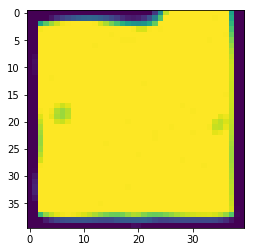

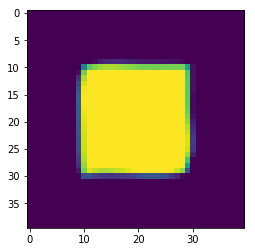

In [13]:
import torch.optim as optim
import torch.nn.functional as F

target = torch.zeros_like(img)
target[0, ..., 2:-2, 2:-2] = 1
target[1, ..., 10:-10, 10:-10] = 1

targetcv = (target[0].detach().permute(1,2,0).numpy()*255).astype(np.uint8)
plt.imshow(targetcv.squeeze(), vmin=0, vmax=1)
plt.show()

targetcv = (target[1].detach().permute(1,2,0).numpy()*255).astype(np.uint8)
plt.imshow(targetcv.squeeze(), vmin=0, vmax=1)
plt.show()


H,W = 4,6
c_dst = torch.zeros(H, W, 2)
c_dst[..., 0] = torch.linspace(0, 1, W)
c_dst[..., 1] = torch.linspace(0, 1, H).unsqueeze(-1)
c_dst = c_dst.view(-1, 2)

theta = torch.zeros(img.shape[0], (c_dst.shape[0]+3), 2, requires_grad=True)
size = img.shape
opt = optim.Adam([theta], lr=1e-2)


for i in range(500):
    opt.zero_grad()
    
    grid = tpspth.tps_grid(theta, torch.tensor(c_dst), size)
    warped = F.grid_sample(img, grid)

    loss = F.mse_loss(warped, target)
    loss.backward()
    opt.step()
    
    if i % 20 == 0:
        print(loss, warped.mean())
    
print(warped.min(), warped.max())
    
warpedcv = (warped[0].detach().permute(1,2,0).numpy()*255).astype(np.uint8)
plt.imshow(warpedcv.squeeze())
plt.show()

warpedcv = (warped[1].detach().permute(1,2,0).numpy()*255).astype(np.uint8)
plt.imshow(warpedcv.squeeze())
plt.show()

#
#warped = F.grid_sample(img, grid)


In [14]:
th = theta.detach().cpu().numpy()

In [15]:
th[0].shape

(27, 2)

In [16]:
grid = tpsnp.compute_densegrid_from_theta(c_dst.numpy(), th[1, :, 0], th[1, :, 1], (40, 40, 1))
i = img[1].permute(1,2,0).numpy().squeeze()
w = cv2.remap(i, grid[:, :, 0] * i.shape[1], grid[:, :, 1] * i.shape[0], cv2.INTER_LINEAR)
w.min(), w.max()

(0.0, 1.0)

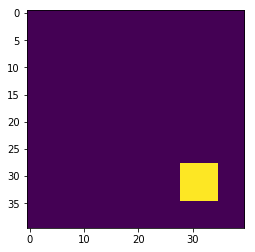

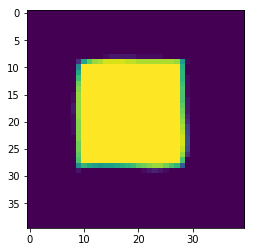

In [17]:
plt.imshow(i); plt.show()
plt.imshow(w)